In [1]:
# import basic modules
import sys
import os
import time
import numpy as np
import h5py
import pandas as pd
import scipy
import torch
import matplotlib
import matplotlib.pyplot as plt
import warnings

# This line ensures the "code" directory is first on your path
# Otherwise the following import lines don't work.
root = os.path.dirname(os.getcwd())
print(root)
sys.path.insert(0,os.path.join(root, 'code'))

# some tools to import
from utils import prf_utils, numpy_utils, stats_utils

/Users/margarethenderson/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/margarethenderson/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/texturemodel


### Download data from Dropbox

https://www.dropbox.com/scl/fo/tczbpdoh01uj5wahwv8ov/ADta4eycRHH4VODZ5kFJ5y4?rlkey=0rupoh64wg4a4umo0pr7ymb8k&st=89zr3z7e&dl=0

NOTE: the files "nsdpreproc.zip" and "texturefeatures.zip" are very big, because they contain information about 8 subjects. You can skip downloading these for now, unless you want all the data. The files "nsdpreproc_S01.zip" and "texturefeatures_S01.zip" will contain everything needed to analyze one subject (S01), which is enough for this notebook.

Put all those files in the same folder "texturemodel" is in. Then unzip.

In [2]:
# do we have access to a GPU? not needed for this, but can be used if available.

def init_cuda():
    
    # Set up CUDA stuff
    print ('#device:', torch.cuda.device_count())
    print ('device#:', torch.cuda.current_device())
    print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

    torch.manual_seed(time.time())
    device = torch.device("cuda:0") #cuda
    torch.backends.cudnn.enabled=True

    print ('\ntorch:', torch.__version__)
    print ('cuda: ', torch.version.cuda)
    print ('cudnn:', torch.backends.cudnn.version())
    print ('dtype:', torch.get_default_dtype())

    return device
    
try:
    init_cuda()
except:
    device = 'cpu:0'

print(device)

#device: 0
cpu:0


### Loading the data

We're using data from the Natural Scenes Dataset:
Allen et al. (2022), Nature Neuroscience

https://www.nature.com/articles/s41593-021-00962-x


In [3]:
# Set some paths: where the preprocessed NSD files live
# If this doesn't work, try manually setting "nsd_path" to wherever you downloaded this.
root_up = os.path.dirname(root)
nsd_path = os.path.join(root_up, 'nsd_preproc')
# nsd_path = '/lab_data/hendersonlab/nsd_preproc'
data_folder = os.path.join(nsd_path, 'data')
labels_folder = os.path.join(nsd_path, 'labels')
stim_folder = os.path.join(nsd_path, 'stimuli')
rois_folder = os.path.join(nsd_path, 'rois')

In [4]:
# Which subject to work with?
# If you downloaded the "nsdpreproc_S01" and "texturefeatures_S01" files, then only subject 1 will work
# if you downloaded the larger "nsdpreproc" and "texturefeatures", you can use 1-8.
subject = 1; 

In [5]:
# Load info about images shown on each trial
info_fn = os.path.join(labels_folder, 'S%d_image_info.csv'%(subject))
print(info_fn)
info = pd.read_csv(info_fn)
# this df has [10,000] elements. Each element is 1 unique image.
# it contains info about the images and where they came from (within the MS COCO dataset).
# the rows of this correspond exactly to the features files (which will be loaded below).

image_order = np.array(info['unique_ims'])
n_reps = np.array(info['n_reps'])

/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/nsd_preproc/labels/S1_image_info.csv


In [8]:
# Load the fMRI data for this subject
data_filename = os.path.join(data_folder, 'S%d_betas_avg_bigmask.hdf5'%subject)
print(data_filename)

t = time.time()
with h5py.File(data_filename, 'r') as data_set:
    values = np.copy(data_set['/betas'])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)
# data is organized as:
# [images x voxels]
# Each image was shown multiple times, and these values capture average response to each image.
# Keep in mind this is already several steps of preprocessing removed from the raw data.
# Steps like motion correction have already been performed to improve signal quality
# And single-trial beta weights were extracted using a GLM analysis.
# Data have also been z-scored, within each session
# Beta weights for repetitions of each image have been averaged.
   
# Some of these values may be nans, only for some subjects
# this is for subjects who didn't complete all 40 sessions of NSD experiment.
# make sure we remove the nans now.
# for subject 1: we should have all the data, no nans.
good_values = ~np.isnan(values[:,0])
print(values.shape)
print(np.sum(~good_values))

voxel_data = values[good_values,:]
print(voxel_data.shape)

# check that nans are exactly where we expect
# nans happen when n_reps=0
assert(np.all(good_values[n_reps>0]))
assert(np.all(~good_values[n_reps==0]))

/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/nsd_preproc/data/S1_betas_avg_bigmask.hdf5
Took 2.49420 seconds to load file
(10000, 19738)
0
(10000, 19738)


In [9]:
# Load info about rois and voxels in the data
# ROI = region of interest. These are visual areas we want to focus on for analysis.
fn = os.path.join(rois_folder, 'S%d_voxel_roi_info.npy'%subject)
print(fn)
rinfo = np.load(fn, allow_pickle=True).item()
# this is a dictionary that contains information about which voxels our data will include.
# voxel_mask is the whole set of voxels we're focusing on. basically all of visual cortex.

voxel_mask = rinfo['voxel_mask']
voxel_index = rinfo['voxel_idx']
voxel_ncsnr = rinfo['ncsnr_full']
brain_nii_shape = rinfo['brain_nii_shape']

/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/nsd_preproc/rois/S1_voxel_roi_info.npy


In [10]:
# Pick one ROI to focus on here.

roi_name = 'V1d' #dorsal part of V1. 
# you could also try other ROI names. 
# can use anything in: rinfo['ret_prf_roi_names']
# for example V2d, hV4...
ind_num = rinfo['ret_prf_roi_names'][roi_name]
roi_inds = rinfo['roi_labels_retino'][voxel_mask]==ind_num
roi_inds_num = np.where(roi_inds)[0]
len(roi_inds), np.sum(roi_inds)


# If you want to try other areas, uncomment one of these blocks:

# roi_name = 'FFA-1' 
# ind_num = rinfo['floc_face_roi_names'][roi_name]
# roi_inds = rinfo['roi_labels_face'][voxel_mask]==ind_num
# roi_inds_num = np.where(roi_inds)[0]
# len(roi_inds), np.sum(roi_inds)

# roi_name = 'PPA' 
# ind_num = rinfo['floc_place_roi_names'][roi_name]
# roi_inds = rinfo['roi_labels_place'][voxel_mask]==ind_num
# roi_inds_num = np.where(roi_inds)[0]
# len(roi_inds), np.sum(roi_inds)

(19738, 756)

### Split data into train/holdout/val partitions

- Training data: used to fit the model weights
- Holdout data (nested validation): used to choose best pRF and ridge parameters
- Validation data: held out until the very end, used to compute the validation set R2.

In [11]:
# fixed random seeds for each subject, to make sure shuffling is repeatable
rndseeds = [171301, 42102, 490304, 521005, 11407, 501610, 552211, 450013, 824387]
si = subject-1 # remember python is zero-indexed. but subjects are one-indexed.

# Always holding out 1000 "shared images", which were seen by all NSD participants, as 
# the validation set. 
val_inds = np.array(info['shared1000'])

# Then take a random 10% of the remaining data, as the nested "holdout" set.
# Holdout set is used to choose ridge parameters and pRF parameters.
# You could experiment with different % holdout, 10% usually works well.
pct_holdout = 0.10
n_images_total = info.shape[0]
n_images_notval = np.sum(~val_inds);
n_images_holdout = int(np.ceil(n_images_notval*pct_holdout))
n_images_trn = n_images_notval - n_images_holdout

inds_notval = np.where(~val_inds)[0]
np.random.seed(rndseeds[si]) 
np.random.shuffle(inds_notval) # this is the only random part

inds_trn = inds_notval[0:n_images_trn]
inds_holdout = inds_notval[n_images_trn:]
assert(len(inds_holdout)==n_images_holdout)

trn_inds = np.isin(np.arange(0, n_images_total), inds_trn)
holdout_inds = np.isin(np.arange(0, n_images_total), inds_holdout)

# remove nan rows here
trn_inds = trn_inds[good_values]
val_inds = val_inds[good_values]
holdout_inds = holdout_inds[good_values]

# apply these indices to split the voxel data and image labels.
voxel_data_trn = voxel_data[trn_inds, :]
voxel_data_val = voxel_data[val_inds, :]
voxel_data_holdout = voxel_data[holdout_inds, :]

n_voxels = voxel_data_trn.shape[1]   
print(voxel_data_trn.shape, voxel_data_val.shape, voxel_data_holdout.shape)

image_order_use = image_order[good_values]
image_inds_trn = image_order_use[trn_inds]
image_inds_val = image_order_use[val_inds]
image_inds_holdout = image_order_use[holdout_inds]


(8100, 19738) (1000, 19738) (900, 19738)


### Fitting a texture statistics encoding model

Following from our paper: Henderson, Tarr, & Wehbe (2023), Journal of Neuroscience.
https://www.jneurosci.org/content/43/22/4144


### Defining the pRF grid

We use a feature-weighted receptive field modeling approach here.

Each voxel has a pRF (population receptive field) that describes its spatial selectivity. Within that pRF, we'll fit a set of weights that capture its feature selectivity.

In [ ]:
# Make pRF grid
# We're making a log-polar grid here.
# Columns are [x, y, sigma]
prf_models = prf_utils.make_log_polar_grid(sigma_range=[0.02, 1], n_sigma_steps=10, \
                              eccen_range=[0, 7/8.4], n_eccen_steps=10, n_angle_steps=16) 
n_prfs = prf_models.shape[0]

These parameters are the same as "which_prf_grid=5" in the fitting code. When we load the pre-computed features below, which have "grid5" in the name, they correspond to this pRF grid.

In [ ]:
# Plot an example pRF (2D gaussian)

prf_ind = 759
print(prf_models[prf_ind])
n_pix = 240

x, y, sigma = prf_models[prf_ind]

# if you change x,y,sigma, what happens?

# x = -0.2;
# y = 0.1;
# sigma = 0.1;

gauss = prf_utils.gauss_2d([x,y],sigma, patch_size=n_pix)
plt.figure(figsize=(4, 4))
plt.pcolormesh(np.flipud(gauss))
plt.axis('square')
center = n_pix/2
plt.axhline(center);
plt.axvline(center)

xp = x * n_pix + center
yp = y * n_pix + center

plt.plot(xp, yp, 'o', color='w')

plt.title('Example pRF, in image space')

In [ ]:
# Plot the entire grid of pRFs. 
# Note that the spacing is in log-polar coordinates, and denser at middle.

def plot_prf_grid(prf_models, xy_circ = [-0.4, -0.4], screen_eccen_deg = 8.4):

    """
    Visualize a grid of pRF positions.
    Makes a subplot for each separate pRF size, with the size drawn as a circle.
    prf_models is [n_prfs x 3], where columns are [x,y,sigma]
    xy_circ is the approximate center of the pRF to draw as a circle 
    (for simplicity, others are just dots)
    """
    
    unique_sizes = np.unique(np.round(prf_models[:,2],4))
    plt.figure(figsize=(18,12));

    for si, size in enumerate(unique_sizes):

        inds = np.where(np.round(prf_models[:,2],4)==size)[0]
        
        prf_models_plot = prf_models[inds,:]
        ind = np.argmin(np.abs(prf_models_plot[:,0] - xy_circ[0]) + np.abs(prf_models_plot[:,1] - xy_circ[1]))
        xy_circ_actual = [prf_models_plot[ind,0], prf_models_plot[ind,1]]

        plt.subplot(3,4,si+1)
        ax = plt.gca()
        plt.plot(prf_models[inds,0]*screen_eccen_deg, prf_models[inds,1]*screen_eccen_deg, '.')
        plt.plot(xy_circ_actual[0]*screen_eccen_deg, xy_circ_actual[1]*screen_eccen_deg, '.',color='k')
        circ = matplotlib.patches.Circle((xy_circ_actual[0]*screen_eccen_deg, \
                                          xy_circ_actual[1]*screen_eccen_deg), \
                                          size*screen_eccen_deg, \
                                          color = [0.2, 0.2, 0.2], fill=False)
        ax.add_artist(circ)
        plt.axis('square')
        # plt.xlim([-1.5*screen_eccen_deg, 1.5*screen_eccen_deg])
        # plt.ylim([-1.5*screen_eccen_deg, 1.5*screen_eccen_deg])
        plt.xlim([-0.8*screen_eccen_deg, 0.8*screen_eccen_deg])
        plt.ylim([-0.8*screen_eccen_deg, 0.8*screen_eccen_deg])
        plt.xticks(np.arange(-8,9,4))
        plt.yticks(np.arange(-8,9,4))

        plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], \
                 [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
        plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], \
                 [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
        plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], \
                 [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
        plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], \
                 [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

        if si>7:
            plt.xlabel('x coord (deg)')
        if np.mod(si,4)==0:
            plt.ylabel('y coord (deg)')

        plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))

plot_prf_grid(prf_models)


### Loading fit parameters

Loading a pre-computed model fit, for one subject. It takes a long time to perform this fitting 
( ~1 hour per subject on a GPU, or much longer on a CPU). So for now let's pretend we already fit it.

To see the entire fitting pipeline, see:

<code/model_fitting/fit_model.py> and <code/model_fitting/fwrf_model.py>

In [18]:
model_fits_path = os.path.join(root_up, 'model_fits')
print(model_fits_path) # check that this is right

# these are the filenames of the best fits for different subjects.
texture_fit_paths = ['S01/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-06-2022_1646_59/all_fit_params.npy', \
                 'S02/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-06-2022_1855_20/all_fit_params.npy',\
                 'S03/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-06-2022_2106_02/all_fit_params.npy', \
                 'S04/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-06-2022_2319_30/all_fit_params.npy', \
                 'S05/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-07-2022_0114_01/all_fit_params.npy', \
                 'S06/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-07-2022_0328_12/all_fit_params.npy', \
                 'S07/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-07-2022_0553_54/all_fit_params.npy', \
                 'S08/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-07-2022_0741_10/all_fit_params.npy']

si = subject - 1
fn2load = os.path.join(model_fits_path, texture_fit_paths[si])
print(fn2load)

out = np.load(fn2load, allow_pickle=True).item()

# the fit file is a dictionary, keys are different parameters
out.keys()

/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/model_fits
/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/model_fits/S01/texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs/Jul-06-2022_1646_59/all_fit_params.npy


dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'average_image_reps', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'prfs_fixed_sigma', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'set_lambda_per_group', 'debug', 'up_to_sess', 'single_sess', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'trial_subset', 'pyr_pca_type', 'group_all_hl_feats', 'do_pyr_varpart'])

In [20]:
# R2 = coefficient of determination, evaluated on validation set.
r2 = out['val_r2']

# check number of voxels, this ensures we have the right subject here
assert(voxel_data_trn.shape[1]==len(r2))

# Choosing a voxel to focus on for the analysis. 
# I'm going to choose the "best voxel" in my ROI of interest (highest R2)
# You can also try other voxels and see how this will differ.
best_in_roi = roi_inds_num[np.argmax(r2[roi_inds])]

voxel_ind = best_in_roi

voxel_ind, r2[voxel_ind]

(10099, array([0.56607735], dtype=float32))

In [21]:
# Pull out all the parameters of the best fit model for each voxel
best_prf_model_pars, best_weights, best_biases, \
      features_mean, features_std, best_prf_models = out['best_params']

# what is the index of the best pRF for the voxel?
prf_ind = best_prf_models[voxel_ind][0]

prf_ind 

504

### Load the pre-computed texture model features

See: <code/feature_extraction/extract_pyramid_texture_features.py> for details on how these were computed.

It's very time consuming to compute these, so for now let's just use the saved features.

In [28]:
features_path = os.path.join(root_up, 'features')
print(features_path) # check that this is right

features_file = os.path.join(features_path, 'pyramid_texture','PCA', \
                             'S%d_4ori_4sf_pcaHL_concat_grid5.h5py'%(subject))
print(features_file)

# inside the features file is a 3D array: [n_images x n_features x n_pRFs]
# we'll just load features for one pRF here, to save memory.
# this is the best pRF for our voxel of interest.
t = time.time()
with h5py.File(features_file, 'r') as data_set:
    print(data_set['/features'].shape)
    values = np.copy(data_set['/features'][:,:,prf_ind])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

# this accounts for any values that are missing in the fmri data array.
f = values[good_values,:]

# some of the features in here are nans - this is because we performed PCA on the features 
# within each subset, and we did this within each pRF. So, there are different numbers of PCs
# kept for different pRFs.
nan_feats = np.isnan(f[0,:])

# f = f
f = f[:,~nan_feats]

# f = scipy.stats.zscore(f, axis=0)

# this file tells us which features correspond to which subset
feature_info_file = os.path.join(features_path, 'pyramid_texture','PCA', \
                             'S%d_4ori_4sf_featurelabels_pcaHL_grid5.npy'%(subject))
print(feature_info_file)
finfo = np.load(feature_info_file, allow_pickle = True).item()
is_low_level = finfo['feature_column_labels']<=4 

# This is the mask for lower-level vs higher-level features.
# Will need this later when doing variance partition analysis.
is_low_level = is_low_level[~nan_feats]

/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/features
/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/features/pyramid_texture/PCA/S1_4ori_4sf_pcaHL_concat_grid5.h5py
(10000, 125, 1456)
Took 1.01281 seconds to load file
/Users/margarethenderson/Dropbox/teaching/upnc_bootcamp/features/pyramid_texture/PCA/S1_4ori_4sf_featurelabels_pcaHL_grid5.npy


### Split the model features the same way we split the data

In [ ]:
f_trn = f[trn_inds,:]
f_val = f[val_inds,:]
f_out = f[holdout_inds,:]

# Z-score the data - this is a step that helps with fit stability.
# I'm computing the normalization parameters (mean and std) on my training data only
# (plus the nested held-out partition), but not the val set.
# this helps reduce leakage of data between train and val partitions.
# then apply those same normalization parameters to the val set too.
f_concat = np.concatenate([f_trn, f_out], axis=0)
# f_concat = f_trn

features_m = np.mean(f_concat, axis=0, keepdims=True) #[:trn_size]
# print(features_m[0,0:10])
features_s = np.std(f_concat, axis=0, keepdims=True) + 1e-6          

f_trn -= features_m
f_trn /= features_s    
f_out -= features_m
f_out /= features_s   
f_val -= features_m
f_val /= features_s  

# add the intercept: a column of ones
f_trn = np.concatenate([f_trn, np.ones(shape=(len(f_trn), 1), dtype=f_trn.dtype)], axis=1)
f_out = np.concatenate([f_out, np.ones(shape=(len(f_out), 1), dtype=f_out.dtype)], axis=1)
f_val = np.concatenate([f_val, np.ones(shape=(len(f_val), 1), dtype=f_val.dtype)], axis=1)

In [56]:
# Send all numpy arrays to PyTorch tensors.
# the main reason we're using torch is because pytorch allows using a GPU for matrix operations. 
# When we have many voxels to fit, this will be way faster than CPU.
# For smaller datasets on CPU, this same basic fitting procedure can also be done using 
# numpy only, or using sklearn (for example sklearn.linear_model.RidgeCV).

vtrn = torch.Tensor(voxel_data_trn[:,voxel_ind:voxel_ind+1]).to(device).to(torch.float64)
vout = torch.Tensor(voxel_data_holdout[:,voxel_ind:voxel_ind+1]).to(device).to(torch.float64)
vval = torch.Tensor(voxel_data_val[:,voxel_ind:voxel_ind+1]).to(device).to(torch.float64)

xtrn = torch.Tensor(f_trn).to(device).to(torch.float64)
xout = torch.Tensor(f_out).to(device).to(torch.float64)
xval = torch.Tensor(f_val).to(device).to(torch.float64)

### Set up ridge parameters

In [44]:
# lambda is the ridge penalty, bigger = more regularization
lambdas = np.logspace(np.log(0.01),np.log(10**5+0.01),9, dtype=np.float32, base=np.e) - 0.01

# We're doing banded ridge regression here. 
# This allows each feature group to have its own lambda value.
# So we are testing every possible combination of the above values.
feature_group_inds = is_low_level
un, n_each = np.unique(feature_group_inds, return_counts=True)
n_feature_groups = len(un)
lambda_combs = numpy_utils.list_all_combs(lambdas, n_feature_groups)
lambda_vectors = np.concatenate([np.tile(lambda_combs[:,ii:ii+1], [1,n_each[ii]]) \
                                      for ii in range(n_feature_groups)], axis=1 )

lambda_vectors= np.concatenate([lambda_vectors, np.zeros((lambda_vectors.shape[0],1))], axis=1)
# [n_lambda_combs x n_features]
# each row of this is a candidate set of lamdbas, applied across the features.

### Solve for weights using ridge regression 

In [45]:
# regression problem is like: y = X @ b
# where y = voxel data
# X = design matrix (features)
# b = beta (regression weights)

# to solve it using ridge regression (L2-regularization), we'll want to do:
# b = (X^T @ X + lambda*I)^(-1) @ X^T @ y
# where I = identity matrix
# and ^(-1) is matrix inverse.

# we're going to solve it in a few stages here. 
# "cofactor" refers to the first part of the equation:
# (X^T @ X + lambda*I)^(-1) @ X^T
# then you multiply this by the training voxel data to get weights.
# the main reason to do it this way is so we can re-use the "cofactor" part for many voxels, 
# which can be faster when we have a lot of voxels. Because the inverse is slow to compute.

# Other ways to do this are: torch.linalg.solve

# xT * x
mult = xtrn.T @ xtrn

# make an identity matrix
ridge_term = torch.eye(xtrn.size()[1], device=device, dtype=torch.float64)

# make versions of this matrix that are adjusted by each possible lambda value
# this is: (X^T @ X + lambda*I)^(-1)
# first dim is the different lambda values.
lambda_matrices = torch.stack([(mult+ridge_term*l).inverse() \
           for l in lambda_vectors], axis=0)

cofactor = torch.tensordot(lambda_matrices, xtrn, dims=[[2],[1]]) 

# solve for weights
beta = torch.tensordot(cofactor, vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]

# predict the response on held-out data, using features from held-out data (xout)
pred = torch.tensordot(xout, beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]

# compute loss for held-out data
# this will tell us the loss for each of the possible lambda values
loss = torch.sum(torch.pow(vout[:,None,:] - pred, 2), dim=0) # [#lambdas, #voxels]

# choose the best lambda value, based on min loss
best_lambda_ind = np.argmin(loss)
print(best_lambda_ind)

# we want to keep the weights that correspond to best lambda values
beta_use = beta[best_lambda_ind,:]

tensor(39)


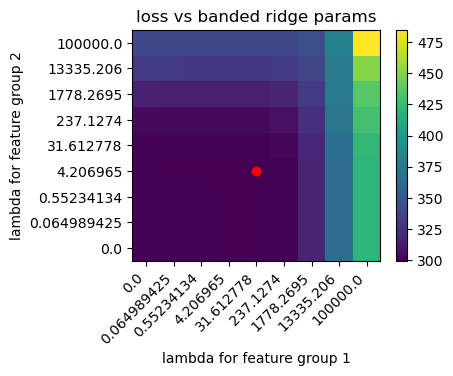

In [160]:
# Visualize the loss versus regularization strength. 
# We want to choose minimum on this plot
# Note that it's 2d because we have 2 lambdas. For normal ridge, this would be just a 1D plot.
# yellow = higher loss/worse

loss_array = loss.numpy() # torch to numpy

loss_reshaped = loss_array.reshape([len(lambdas), len(lambdas)])
# lambda_reshaped = lambda_combs.reshape([len(lambdas), len(lambdas), 2])
# loss_reshaped[loss_reshaped==np.min(loss_reshaped)]=-100
plt.figure(figsize=(4,3))
plt.pcolormesh(loss_reshaped.T)
plt.colorbar()
plt.title('loss vs banded ridge params')
plt.xlabel('lambda for feature group 1')
plt.ylabel('lambda for feature group 2')
# print(lambdas)
plt.xticks(np.arange(0.5, len(lambdas), 1), lambdas, rotation=45, ha='right');
plt.yticks(np.arange(0.5, len(lambdas), 1), lambdas);

best_loss_coords = np.unravel_index(best_lambda_ind, loss_reshaped.shape)

plt.plot(best_loss_coords[0] + 0.5, best_loss_coords[1] + 0.5, 'o', color='r')

### Predict held-out data

In [47]:
# predict voxel response in held-out validation data here.
pred = xval @ beta_use

# remember to turn these back into numpy, from torch.
# sometimes tensors will give errors in your subsequent numpy code.
actual_array = vval.numpy()
pred_array = pred.numpy()

### Try yourself: evaluate the model fit
- Compute R2 (coefficient of determination) and correlation coefficient
- Make a plot that shows the alignment between real and predicted data.

(answer is in hidden cells)

In [ ]:

# Compute R2 and correlation coefficient for this model fit.

def get_r2(actual,predicted):
    """
    This computes the coefficient of determination (R2).
    Always goes along first dimension (i.e. the trials/samples dimension)
    MAKE SURE INPUTS ARE ACTUAL AND THEN PREDICTED, NOT FLIPPED
    """
    ssres = np.sum(np.power((predicted - actual),2), axis=0);
    sstot = np.sum(np.power((actual - np.mean(actual, axis=0)),2), axis=0);
    r2 = 1-(ssres/sstot)
    
    return r2


r2 = stats_utils.get_r2(actual_array, pred_array)

corrcoef = np.corrcoef(actual_array[:,0], pred_array[:,0])[1,0]

print('R2 = %.5f, correlation = %.5f'%(r2, corrcoef))


In [ ]:

# check this against what's in the saved file.
# there are some small differences in the fitting code, so it may be off by a bit.
out['val_r2'][voxel_ind], out['val_cc'][voxel_ind]

In [ ]:

# Visualizing the fit accuracy

# scatter plot: each point is one image

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(actual_array, pred_array, 'o')
plt.xlabel('Actual signal')
plt.ylabel('Predicted signal')
plt.axis('equal')

plt.axvline(0, color='k')
plt.axhline(0, color='k')

# line plot: x axis are images, y axis is voxel response

plt.subplot(1, 2, 2)
plt.plot(actual_array)
plt.plot(pred_array)

plt.xlabel('image number')
plt.ylabel('z-scored beta weight')

plt.legend(['Actual','Predicted'])

plt.suptitle('%s voxel, num %d'%(roi_name, voxel_ind))

### Variance partitioning

Compute the unique variance explained by each feature type.

To do this, we leave out a set of feature at a time, and test how much the R2 will drop. 

Full R2 - partial R2 will give us the unique variance.

### Try implementing this yourself
- Compute the unique variance explained by the lower-level features, and the unique variance explained higher-level features
- Compute the shared variance between the lower-level and higher-level feautures
- To start: use the variable "is_low_level" that was defined previously. This tells you which features in 'xtrn' are in which group. (note that it doesn't include the intercept/last column)

In [ ]:

# first we'll define the set of model versions to use.
# make feature masks that define which features to keep in each version.
partial_names = ['full','leave_out_HL','leave_out_LL']

n_feat = f_trn.shape[1]
partial_masks = np.stack([np.ones([n_feat,]), \
                 np.concatenate([is_low_level, np.array([1])]), \
                 np.concatenate([~is_low_level, np.array([1])])])
partial_masks = partial_masks.astype(bool)
# [n_partial_models x n_features]
# Note this matrix includes the intercept. keep the intercept in all partial model versions.

In [ ]:

r2_each = np.zeros((len(partial_names),))

for pi in range(len(partial_names)):

    pname = partial_names[pi]
    print(pname)
    pmask = partial_masks[pi]
    
    # select just the features of interest here
    xtrn_use = xtrn[:,pmask]
    xout_use = xout[:,pmask]
    xval_use = xval[:,pmask]
    lambda_vec_use = lambda_vectors[:,pmask]
    
    print(xtrn_use.shape)
    
    # xT * x
    mult = xtrn_use.T @ xtrn_use
    
    # make an identity matrix
    ridge_term = torch.eye(xtrn_use.size()[1], device=device, dtype=torch.float64)
    
    # make versions of this matrix that are adjusted by each possible lambda value
    # this is: (X^T @ X + lambda*I)^(-1)
    # first dim is the different lambda values.
    lambda_matrices = torch.stack([(mult+ridge_term*l).inverse() \
               for l in lambda_vec_use], axis=0)
    
    cofactor = torch.tensordot(lambda_matrices, xtrn_use, dims=[[2],[1]]) 
    
    # solve for weights
    beta = torch.tensordot(cofactor, vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]
    
    # predict the response on held-out data, using features from held-out data (xout)
    pred = torch.tensordot(xout_use, beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
    
    # compute loss for held-out data
    loss = torch.sum(torch.pow(vout[:,None,:] - pred, 2), dim=0) # [#lambdas, #voxels]
    
    # choose the best lambda value
    best_lambda_ind = np.argmin(loss)
    
    # we want to keep the weights that correspond to best lambda values
    beta_use = beta[best_lambda_ind,:]

    # predict voxel response in held-out validation data here.
    pred = xval_use @ beta_use
    
    # remember to turn these back into numpy, from torch.
    # sometimes tensors will give errors in your subsequent numpy code.
    actual_array = vval.numpy()
    pred_array = pred.numpy()
    
    r2 = get_r2(actual_array, pred_array)
    
    corrcoef = np.corrcoef(actual_array[:,0], pred_array[:,0])[1,0]

    r2_each[pi] = r2

    print('R2 = %.5f, correlation = %.5f'%(r2, corrcoef))

In [ ]:

# Compute unique variance and shared variance.

# r2_each is: [full, lower-level only, higher-level only]
unique_lowerlevel = r2_each[0] - r2_each[2]
unique_higherlevel = r2_each[0] - r2_each[1]
shared_var = r2_each[1] + r2_each[2] - r2_each[0]
assert (unique_lowerlevel + unique_higherlevel + shared_var) == r2_each[0]
# they should sum to the total R2.

print('Unique variance lower-level features: %.5f'%(unique_lowerlevel))
print('Unique variance higher-level features: %.5f'%(unique_higherlevel))
print('Shared variance: %.5f'%(shared_var))

Does the result make sense?

If you go back to the top of the script, you can try other ROIs. Do the results differ between V1 and FFA?

### Look at fit parameters across voxels

Using the saved model fits that we already loaded, let's examine some of the fit parameters in more detail.

Variable "out" contains info about the model fitting for our subject of interest.

Noise ceiling: For each voxel, this is a measure of the theoretical variance 
in its response that can be explained by a model.
It's like a "ceiling" for how good R2 can be.

See the section "Noise ceiling estimation" here for details: https://www.nature.com/articles/s41593-021-00962-x#Sec14

In [103]:
r2_val = out['val_r2'] # this is R2 for all the voxels

noise_ceiling = rinfo['noise_ceiling_avgreps'] / 100

### Try yourself:
- Compare the R2 between different ROIs. Which ROIs have the best overall R2? Why?
- Visualize the relationship between the noise ceiling and R2. 
- Compare how this differs for different ROIs.


In [ ]:

for roi_name in ['V1d','V1v','V2d','V2v','V3d','V3v','hV4']:
        
    ind_num = rinfo['ret_prf_roi_names'][roi_name]
    roi_inds = rinfo['roi_labels_retino'][voxel_mask]==ind_num
    roi_inds_num = np.where(roi_inds)[0]
    len(roi_inds), np.sum(roi_inds)

    m = np.mean(r2_val[roi_inds])
    s = np.std(r2_val[roi_inds])

    print('%s: R2 = %.2f +/- %.2f'%(roi_name, m, s))

Text(0.5, 1.0, 'V1d')

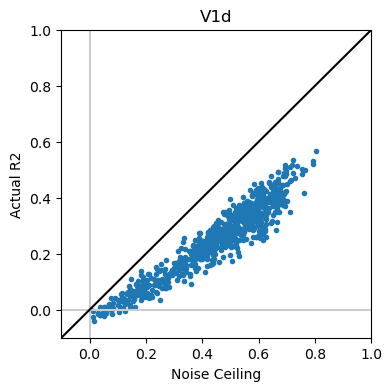

In [104]:

roi_name = 'V1d' #dorsal part of V1. 
# you could also try other ROI names. 
# can use anything in: rinfo['ret_prf_roi_names']
# for example V2d, hV4...
ind_num = rinfo['ret_prf_roi_names'][roi_name]
roi_inds = rinfo['roi_labels_retino'][voxel_mask]==ind_num
roi_inds_num = np.where(roi_inds)[0]
len(roi_inds), np.sum(roi_inds)


plt.figure(figsize=(4, 4))
plt.plot(noise_ceiling[roi_inds], r2_val[roi_inds],'.')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.axvline(0, color=[0.8, 0.8, 0.8])
plt.xlim([-0.1, 1])
plt.ylim([-0.1, 1])
plt.plot([-0.1, 1], [-0.1, 1], '-', color='k')
plt.xlabel('Noise Ceiling')
plt.ylabel('Actual R2')

plt.title('%s'%roi_name)

### Pull out the pRF parameters for single voxels

In [108]:
prf_pars = out['best_params'][0][:,0,:]
x = prf_pars[:,0]
y = prf_pars[:,1]

# convert these to coordinates of degrees visual angle.
screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
# angle = polar angle, in a counter-clockwise direction from far right.
# eccentricity = distance from center of screen.
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

unique_size = np.unique(size_fwrf.round(3))
unique_eccen = np.unique(eccen_fwrf.round(3))
unique_size, unique_eccen
n_size = len(unique_size)
n_eccen = len(unique_eccen)

### Try yourself:
- Compare pRF parameters for different ROIs. How do the distributions of size and eccentricity vary across areas?
- Compare relationships between pRF size and eccentricity. Are these related?
- Look at the distribution of pRF angles. Is it uniform? Are some angles more common?
- How do pRF parameters relate to the R2 for single voxels?

In [153]:
# first, choosing good voxels based on their R2

r2_val = out['val_r2']
r2_thresh = 0.10 
# set a threshold for choosing good voxels to work with.
# you can experiment with different values of r2_thresh

good_voxels = np.squeeze(r2_val > r2_thresh)

# use the "good_voxels" when examining pRF parameters, because these are the fits we trust most.

In [ ]:

# making violin plots: this is like a vertical histogram.

# size

plt.figure(figsize=(7,3))

color = [0.4, 0.4, 0.4]
rnames = ['V1d','V1v','V2d','V2v','V3d','V3v','hV4']
for rr, roi_name in enumerate(rnames):

    ind_num = rinfo['ret_prf_roi_names'][roi_name]
    roi_inds = (rinfo['roi_labels_retino'][voxel_mask]==ind_num) & good_voxels
    roi_inds_num = np.where(roi_inds)[0]

    vals = size_fwrf[roi_inds]

    parts = plt.violinplot(vals,[rr])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.plot(rr, np.median(vals), 'o',\
                     markeredgecolor='k',markerfacecolor='none')

plt.xticks(np.arange(len(rnames)), rnames);
plt.ylabel('pRF size (deg visual angle)')


# eccentricity

plt.figure(figsize=(7,3))

color = [0.4, 0.4, 0.4]
rnames = ['V1d','V1v','V2d','V2v','V3d','V3v','hV4']
for rr, roi_name in enumerate(rnames):

    ind_num = rinfo['ret_prf_roi_names'][roi_name]
    roi_inds = (rinfo['roi_labels_retino'][voxel_mask]==ind_num) & good_voxels
    roi_inds_num = np.where(roi_inds)[0]

    vals = eccen_fwrf[roi_inds]

    parts = plt.violinplot(vals,[rr])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.plot(rr, np.median(vals), 'o',\
                     markeredgecolor='k',markerfacecolor='none')

plt.xticks(np.arange(len(rnames)), rnames);
plt.ylabel('pRF eccentricity (deg visual angle)')


# angle

plt.figure(figsize=(7,3))

color = [0.4, 0.4, 0.4]
rnames = ['V1d','V1v','V2d','V2v','V3d','V3v','hV4']
for rr, roi_name in enumerate(rnames):

    ind_num = rinfo['ret_prf_roi_names'][roi_name]
    roi_inds = (rinfo['roi_labels_retino'][voxel_mask]==ind_num) & good_voxels
    roi_inds_num = np.where(roi_inds)[0]

    vals = angle_fwrf[roi_inds]

    parts = plt.violinplot(vals,[rr])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.plot(rr, np.median(vals), 'o',\
                     markeredgecolor='k',markerfacecolor='none')

plt.xticks(np.arange(len(rnames)), rnames);
plt.ylabel('pRF angle (polar angle deg)')

In [ ]:

# size versus eccentricity

for roi_name in ['V1d','hV4']:
        
    ind_num = rinfo['ret_prf_roi_names'][roi_name]
    roi_inds = (rinfo['roi_labels_retino'][voxel_mask]==ind_num) & good_voxels
    roi_inds_num = np.where(roi_inds)[0]
    
    size_lims = [-0.5,8.0]
    eccen_lims = [-0.5,8.0]
    size_ticks = np.arange(0,9,2)
    eccen_ticks = np.arange(0,9,2)
    
    plt.figure(figsize=(4,4))
    
    xvals = eccen_fwrf[roi_inds].round(3)
    yvals = size_fwrf[roi_inds].round(3)
    
    xbinned, ybinned, ybin_std = numpy_utils.bin_ydata_by_xdata(xvals, yvals, \
                                                                linear_bins=False,
                                                                n_bins=10, return_std=True, use_unique=True)
    
    plt.errorbar(xbinned, ybinned, ybin_std, color='k')
    
    plt.plot(xvals, yvals,'.',color=[0.6, 0.6, 0.6], alpha=0.2)
    
    plt.xlim(eccen_lims)
    plt.ylim(size_lims)
    
    plt.yticks(size_ticks)
    plt.ylabel('size (deg)')
    
    plt.xticks(eccen_ticks)
    plt.xlabel('eccen (deg)')
    
    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.axvline(0,color=[0.8, 0.8, 0.8])
    
    plt.title(roi_name)


In [ ]:

# Plotting pRF coverage for an example area.
# Each circle here is one voxel.

# Compare these plots for V1d and V1v. How/why are they different?

for roi_name in ['V1d','V1v']:
        
    ind_num = rinfo['ret_prf_roi_names'][roi_name]
    roi_inds = (rinfo['roi_labels_retino'][voxel_mask]==ind_num) & good_voxels
    roi_inds_num = np.where(roi_inds)[0]
    
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(1,1,1)
    
    for vi, vidx in enumerate(roi_inds_num):
    
        plt.plot(x[vidx]*screen_eccen_deg, y[vidx]*screen_eccen_deg,'.',color='k')
        circ = matplotlib.patches.Circle((x[vidx]*screen_eccen_deg, \
                                          y[vidx]*screen_eccen_deg), \
                                          size_fwrf[vidx], 
                                          color = [0.8, 0.8, 0.8], fill=False)
        ax.add_artist(circ)
    
    plt.axis('square')
    
    plt.xlim([-1.5*screen_eccen_deg, 1.5*screen_eccen_deg])
    plt.ylim([-1.5*screen_eccen_deg, 1.5*screen_eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    boxcolor = [0.6, 0.6, 0.6]
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], \
             [screen_eccen_deg/2, -screen_eccen_deg/2],color=boxcolor)
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], \
             [screen_eccen_deg/2, -screen_eccen_deg/2],color=boxcolor)
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], \
             [screen_eccen_deg/2, screen_eccen_deg/2],color=boxcolor)
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], \
             [-screen_eccen_deg/2, -screen_eccen_deg/2],color=boxcolor)
    
    plt.xlabel('x coord (deg)')
    plt.ylabel('y coord (deg)')
    
    plt.title('%s (%d vox)'%(roi_name, len(roi_inds_num)))
